# **Import Necessary Libraries**

In [18]:
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, zipfile, shutil, random
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten

# **Data Load**

In [2]:
zip_path = "/content/archive_kidneystone.zip"
extract_path = "/content/archive_kidneystone"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

inner_items = os.listdir(extract_path)
if len(inner_items) == 1 and os.path.isdir(os.path.join(extract_path, inner_items[0])):
    original_data = os.path.join(extract_path, inner_items[0])
else:
    original_data = extract_path

print("Dataset located at:", original_data)
print("Classes found:", os.listdir(original_data))

Dataset located at: /content/archive_kidneystone
Classes found: ['Normal', 'stone']


# **Visualisation of Normal and Stone Classes**

Detected classes: ['Normal', 'stone']


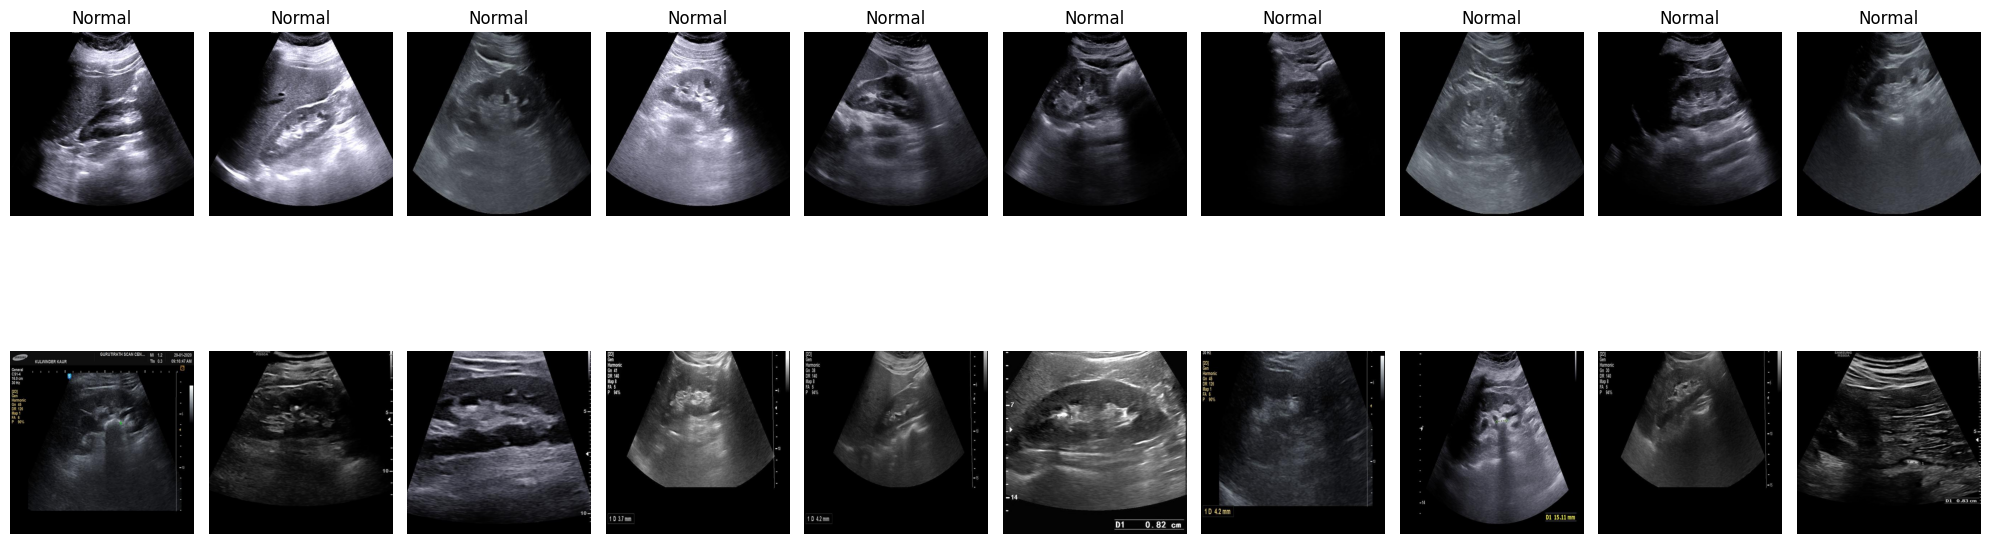

In [17]:
classes = sorted([d for d in os.listdir(original_data) if os.path.isdir(os.path.join(original_data, d))])
print("Detected classes:", classes)

plt.figure(figsize=(20, 8))

index = 1
for cls in classes:
    cls_path = os.path.join(original_data, cls)
    images = os.listdir(cls_path)[:10]

    for img_name in images:
        img_path = os.path.join(cls_path, img_name)
        img = mpimg.imread(img_path)

        plt.subplot(len(classes), 10, index)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        if index <= 10:
            plt.title(cls)
        index += 1

plt.tight_layout()
plt.show()

# **Train Test Validation Function Creation**


In [3]:
def create_split_folders(input_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)

    classes = os.listdir(input_dir)
    for cls in classes:
        cls_path = os.path.join(input_dir, cls)
        images = os.listdir(cls_path)
        random.shuffle(images)
        total = len(images)

        train_end = int(train_ratio * total)
        val_end = int((train_ratio + val_ratio) * total)

        splits = {
            'train': images[:train_end],
            'val': images[train_end:val_end],
            'test': images[val_end:]
        }

        for split, split_images in splits.items():
            split_dir = os.path.join(output_dir, split, cls)
            os.makedirs(split_dir, exist_ok=True)
            for img in split_images:
                shutil.copy(os.path.join(cls_path, img), split_dir)

split_data_path = "/content/kidney_data_split"
create_split_folders(original_data, split_data_path)

train_dir = os.path.join(split_data_path, 'train')
val_dir = os.path.join(split_data_path, 'val')
test_dir = os.path.join(split_data_path, 'test')

#  **Data Preprocessing & Augmentation**

In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 6590 images belonging to 2 classes.
Found 1412 images belonging to 2 classes.
Found 1414 images belonging to 2 classes.


# **EfficientNet Model Building**

In [5]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))

for layer in base_model.layers[-20:]:
    layer.trainable = True

model = Sequential([
    base_model,
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 256)      │     2,949,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,493,156 (28.58 MB)

 Trainable params: 7,450,365 (28.42 MB)

 Non-trainable params: 42,791 (167.16 KB)

# **Model Training**

In [7]:
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_kidney_model.h5', save_best_only=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.8833 - loss: 0.2905

206/206 ━━━━━━━━━━━━━━━━━━━━ 78s 378ms/step - accuracy: 0.8833 - loss: 0.2904 - val_accuracy: 0.7288 - val_loss: 0.4884
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9187 - loss: 0.2133

206/206 ━━━━━━━━━━━━━━━━━━━━ 79s 383ms/step - accuracy: 0.9187 - loss: 0.2132 - val_accuracy: 0.9469 - val_loss: 0.1680
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.9390 - loss: 0.1698

206/206 ━━━━━━━━━━━━━━━━━━━━ 78s 378ms/step - accuracy: 0.9391 - loss: 0.1698 - val_accuracy: 0.9462 - val_loss: 0.1530
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 77s 375ms/step - accuracy: 0.9436 - loss: 0.1628 - val_accuracy: 0.5935 - val_loss: 0.7300
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 77s 375ms/step - accuracy: 0.9467 - loss: 0.1421 - val_accuracy: 0.5878 - val_loss: 0.6976
Epoch 6/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 77s 372ms/step - accuracy: 0.9613 - loss: 0.1132 - val_accuracy: 0.9193 - val_loss: 0.1968
Epoch 7/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 77s 375ms/step - accuracy: 0.9661 - loss: 0.1044 - val_accuracy: 0.9271 - val_loss: 0.1610
Epoch 8/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 77s 371ms/step - accuracy: 0.9710 - loss: 0.0856 - val_accuracy: 0.7790 - val_loss: 0.3649
Epoch 9/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 77s 375ms/step - accuracy: 0.9707 - loss: 0.0833 - val_accuracy: 0.9490 - val_loss: 0.1589
Epoch 10/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.9705 - loss: 0.0890

206/206 ━━━━━━━━━━━━━━━━━━━━ 78s 377ms/step - accuracy: 0.9705 - loss: 0.0890 - val_accuracy: 0.9681 - val_loss: 0.1112


# **Model Evaluation**

45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 306ms/step - accuracy: 0.9571 - loss: 0.1455
Test Accuracy: 96.96%
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 212ms/step
Classification Report:
               precision    recall  f1-score   support

      Normal       0.99      0.94      0.97       663
       Stone       0.95      0.99      0.97       751

    accuracy                           0.97      1414
   macro avg       0.97      0.97      0.97      1414
weighted avg       0.97      0.97      0.97      1414



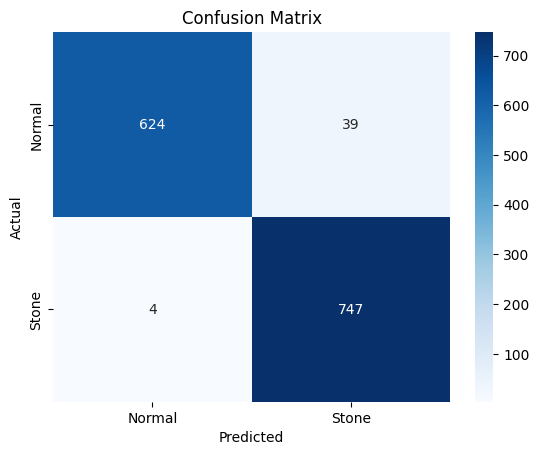

In [8]:
model.load_weights('best_kidney_model.h5')

loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

y_pred = (model.predict(test_generator) > 0.5).astype("int32")
y_true = test_generator.classes

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['Normal', 'Stone']))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Normal', 'Stone'],
            yticklabels=['Normal', 'Stone'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# **AUC-ROC Curve Visualisation**

45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step


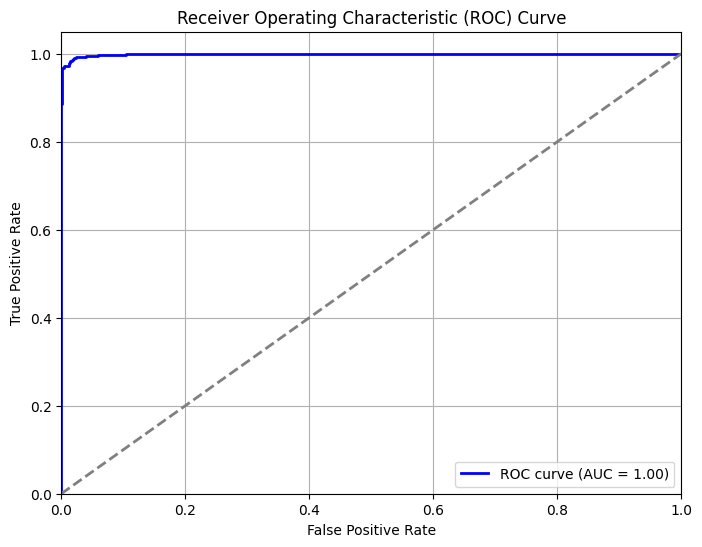

In [19]:
y_prob = model.predict(test_generator)

fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# **Training and Loss Curves Visualisation**

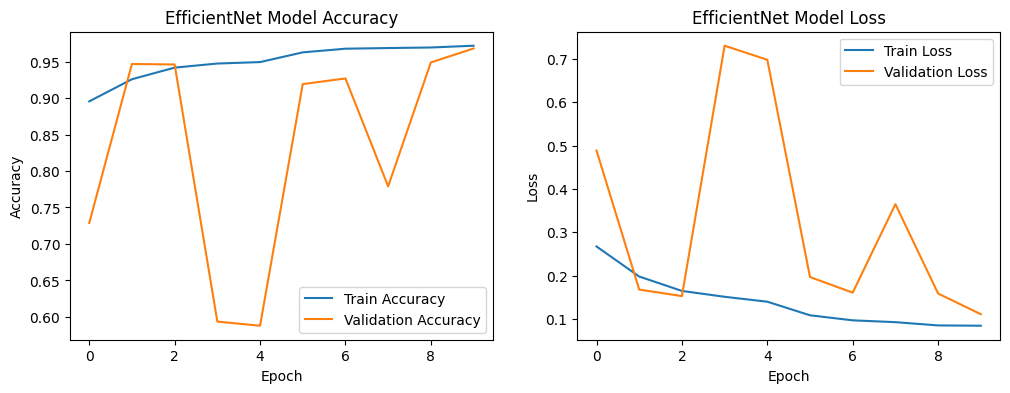

In [20]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('EfficientNet Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('EfficientNet Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()